In [4]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import pathlib
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import polars as pl

In [16]:
def calculate_wait_times(rts: list, group_type:str, only_daytime:bool = True):

    rt_to_pid = pd.read_parquet("rt_to_pid.parquet")
    pids = rt_to_pid[rt_to_pid['rt'].isin(rts)]['pid'].unique()
    
    trips = []
    for pid in pids:
        try:
            df_trips = pl.read_parquet(f'../cta-stop-etl/out/trips/trips_{pid}_full.parquet')
            df_trips = df_trips.to_pandas()
        except:
            print(f"Do not have pattern {pid} for route. Skipping")
            continue

        df_trips = df_trips[(df_trips['typ'] == 'S') & (df_trips['bus_stop_time'].dt.hour.between(6, 20) if only_daytime else True)]
        df_trips['pid'] = int(pid)
    
        dict = df_trips.to_dict(orient="records")
        trips += dict

    df_trips_all = pd.DataFrame(trips)

    rt_to_pid = pd.read_parquet('rt_to_pid.parquet') 
    full_df = df_trips_all.merge(rt_to_pid, how="left", on="pid")

    full_df = full_df.sort_values(['p_stp_id','bus_stop_time'])
    full_df['wait_time_minutes'] = full_df.groupby('p_stp_id')['bus_stop_time'].diff().dt.total_seconds()/60


    full_df['month'] = full_df['bus_stop_time'].dt.month
    full_df['hour'] = full_df['bus_stop_time'].dt.hour
    full_df['dayofweek'] = full_df['bus_stop_time'].dt.dayofweek
    full_df['dayofyear'] = full_df['bus_stop_time'].dt.dayofyear


    #grouped_df = full_df.groupby(['rt', group_type])['wait_time_minutes'].agg(['mean','median', 'std', 'count']).reset_index()
    grouped_df = full_df.groupby(['rt', group_type])['wait_time_minutes'].agg(['mean','median', 'std', 'count']).reset_index()

    grouped_df['ci95_hi'] = grouped_df['mean'] + 1.96*grouped_df['std']/np.sqrt(grouped_df['count'])
    grouped_df['ci95_low'] = grouped_df['mean'] - 1.96*grouped_df['std']/np.sqrt(grouped_df['count'])
        
        
    #     df_trips = df_trips.filter(pl.col('typ') == 'S')
    #     df_trips = df_trips.with_columns(pl.lit(pid).cast(pl.Int64).alias('pid'))
        
    #     dicts = df_trips.to_dicts()
    #     trips.extend(dicts)

    # df_trips_all = pl.DataFrame(trips)
    # rt_to_pid = pl.read_parquet('rt_to_pid.parquet') 

    # full_df = df_trips_all.join(rt_to_pid, on='pid', how='left')

    # full_df = full_df.sort(by=['p_stp_id', 'bus_stop_time'])
    # full_df = full_df.groupby(['p_stp_id']).with_columns(
    #     (pl.col('bus_stop_time').diff().dt.total_seconds() / 60).alias('wait_time_minutes')
    # )

    # full_df = full_df.with_columns((pl.col('bus_stop_time').dt.hour()).alias('hour'), 
    #                   (pl.col('bus_stop_time').dt.month()).alias('month'),
    #                   (pl.col('bus_stop_time').dt.year()).alias('year'),
    #                     (pl.col('bus_stop_time').dt.day()).alias('day'))

    # # Group by 'rt' and 'grouping', and compute aggregations
    # grouped_df = (
    #     full_df
    #     .groupby(['rt', grouping])
    #     .agg([pl.mean('wait_time_minutes').alias('mean'),
    #           pl.median('wait_time_minutes').alias('median'),
    #           pl.std('wait_time_minutes').alias('std'),
    #           pl.count('wait_time_minutes').alias('count')
    #           ])
    # )

    # # Compute the confidence intervals
    # grouped_df = grouped_df.with_columns([
    #     (pl.col('mean') + 1.96 * pl.col('std') / np.sqrt(pl.col('count'))).alias('ci95_hi'),
    #     (pl.col('mean') - 1.96 * pl.col('std') / np.sqrt(pl.col('count'))).alias('ci95_low')
    # ])


    return grouped_df

In [5]:
rt_to_pid = pd.read_parquet("rt_to_pid.parquet")
pids = rt_to_pid['pid'].unique()

trips = []
for pid in pids:
    try:
        df_trips = pl.read_parquet(f'../cta-stop-etl/out/trips/trips_{pid}_full.parquet')
        df_trips = df_trips.to_pandas()
    except:
        print(f"Do not have pattern {pid}. Skipping")
        continue

    df_trips = df_trips[(df_trips['typ'] == 'S') & (df_trips['bus_stop_time'].dt.hour.between(6, 20))]
    df_trips['pid'] = int(pid)

    dict = df_trips.to_dict(orient="records")
    trips += dict

df_trips_all = pd.DataFrame(trips)

full_df = df_trips_all.merge(rt_to_pid, how="left", on="pid")

full_df = full_df.sort_values(['p_stp_id','bus_stop_time'])
full_df['wait_time_minutes'] = full_df.groupby('p_stp_id')['bus_stop_time'].diff().dt.total_seconds()/60


full_df['month'] = full_df['bus_stop_time'].dt.month
full_df['hour'] = full_df['bus_stop_time'].dt.hour
full_df['dayofweek'] = full_df['bus_stop_time'].dt.dayofweek
full_df['dayofyear'] = full_df['bus_stop_time'].dt.dayofyear


#grouped_df = full_df.groupby(['rt', group_type])['wait_time_minutes'].agg(['mean','median', 'std', 'count']).reset_index()
grouped_df = full_df['wait_time_minutes'].agg(['mean','median', 'std', 'count']).reset_index()

grouped_df['ci95_hi'] = grouped_df['mean'] + 1.96*grouped_df['std']/np.sqrt(grouped_df['count'])
grouped_df['ci95_low'] = grouped_df['mean'] - 1.96*grouped_df['std']/np.sqrt(grouped_df['count'])
    
        

Do not have pattern 17466. Skipping
Do not have pattern 7386. Skipping
Do not have pattern 7446. Skipping
Do not have pattern 7448. Skipping
Do not have pattern 21482. Skipping
Do not have pattern 4529. Skipping
Do not have pattern 7861. Skipping
Do not have pattern 8098. Skipping


In [7]:
def chart_wait_times(grouped_df: pd.DataFrame,type:str):
    rts = grouped_df['rt'].unique()
    grouping = grouped_df.columns[1]

    plt.figure(figsize=(10, 6))

    # Plot a line for each month
    for rt in rts:
        subset = grouped_df[grouped_df['rt'] == rt]
        plt.plot(subset[grouping], subset[type], marker='o', label=rt)
        if type == 'mean':
            plt.fill_between(subset[grouping], subset['ci95_hi'], subset['ci95_low'], alpha=0.2)

    plt.xlabel(f"{grouping}")
    plt.ylabel(f'{type} Wait Time (Minutes)')
    plt.title(f'{type} Wait Time by {grouping}')
    # plt.ylim(0, 60)
    plt.legend(title='Route')
    plt.grid(True)
    plt.show()

In [19]:
test_df = calculate_wait_times(['4'], 'month')

Do not have pattern 19385 for route. Skipping


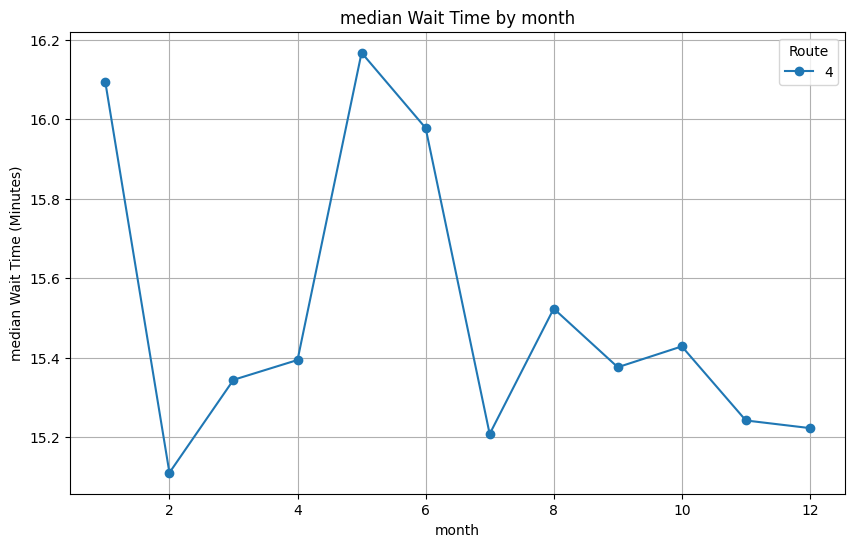

In [22]:
chart_wait_times(test_df,'median')